In [1]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [3]:
# Especificar columnas
relevant_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','Sem','Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante']
num_columns = ['Existencia','fiDesplazamiento','VentaPromedio']
cat_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','Sem']
target = ['Y_Faltante']

In [4]:
dtype = {'SKU':'object','FORMATO':'object','REGION':'object','Tienda':'object','Categoria':'object','Proveedor':'object','CLASE':'object','SCLASE':'object','Mes':'object','DiaSem':'object','Sem':'object','Existencia':'float','fiDesplazamiento':'float',
\
'VentaPromedio':'float','Y_Faltante':'int'}

In [5]:
# Abrir el archivo
file = '8semanas.csv'
data = pd.read_csv(file, header=0,low_memory=False, usecols=relevant_columns,dtype=dtype)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 3304660  columns: 10


In [6]:
# Abrir el archivo
file = 'datos_entrenamiento.csv'
data_2 = pd.read_csv(file, header=0,low_memory=False, encoding='latin-1',usecols=relevant_columns,dtype=dtype)
print('rows:', data_2.shape[0], ' columns:', data_2.shape[1])

rows: 5094322  columns: 10


In [7]:
# Abrir el archivo
#file = '1semana.csv'
#data_3 = pd.read_csv(file, header=0,low_memory=False, encoding='latin-1',usecols=relevant_columns,dtype=dtype)
#print('rows:', data_3.shape[0], ' columns:', data_3.shape[1])

In [8]:
data = pd.concat([data,data_2],join='inner')
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 8398982  columns: 10


In [9]:
# Abrir el archivo que contiene el conjunto de validación 
file_val = '1semana.csv'
data_val = pd.read_csv(file_val, header=0,low_memory=False, usecols=relevant_columns,encoding='latin-1',dtype=dtype)
print('rows:', data_val.shape[0], ' columns:', data_val.shape[1])

rows: 2608114  columns: 10


In [10]:
data = data.dropna()
data_val = data_val.dropna()

In [11]:
# Imprime reporte con porcentaje de outliers en nuestro conjunto de datos
outliers = {}
for i in range(6,8):
    min_t = data[data.columns[i]].mean() \
            - (3 * data[data.columns[i]].std())
    max_t = data[data.columns[i]].mean() \
            + (3 * data[data.columns[i]].std())
    count = 0
for j in data[data.columns[i]]:
    if j < min_t or j > max_t:
        count += 1
percentage = count/data.shape[0]
outliers[data.columns[i]] = "%.3f" % percentage
print(outliers)

{'fiDesplazamiento': '0.005'}


yes %: 50.210259236047804- no %: 49.789740763952196


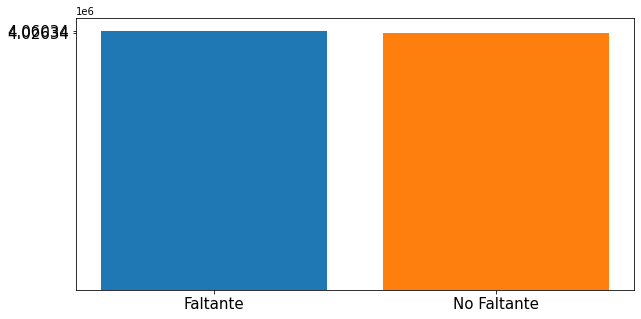

In [12]:
# Verificamos que el conjunto de datos está perfectamente balanceado
# Revisamos la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [13]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = data[data["Y_Faltante"] == 1]
data_no = data[data["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
chedraui_cd = balanced_data.reset_index(drop=True)

yes %: 50.0- no %: 50.0


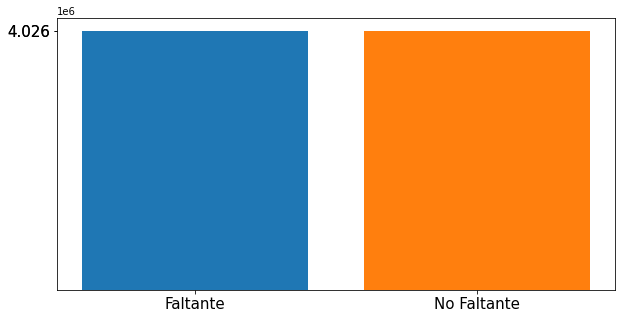

In [14]:
# Revisamos (de nuevo) la proporción de datos
target = chedraui_cd['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [15]:
X_train = data.drop('Y_Faltante',axis=1)
y_train = data.Y_Faltante
X_val = data_val.drop('Y_Faltante',axis=1)
y_val = data_val.Y_Faltante

In [16]:
indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos

array([0, 1, 2, 3, 4, 5])

In [17]:
num_ind = np.where(X_train.dtypes != object)[0]
num_ind

array([6, 7, 8])

In [18]:
model = CatBoostClassifier(
    l2_leaf_reg=int(2.0),
    custom_loss=[metrics.Accuracy()],
    random_seed=0,
    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
    task_type='GPU',
    #iterations=250
)

In [19]:
model.fit(
    X_train, y_train,
    cat_features=indices_categoricos,
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6494742	test: 0.6608315	best: 0.6608315 (0)	total: 798ms	remaining: 13m 17s
1:	learn: 0.6090130	test: 0.6326719	best: 0.6326719 (1)	total: 1.68s	remaining: 13m 58s
2:	learn: 0.5733274	test: 0.6064948	best: 0.6064948 (2)	total: 2.59s	remaining: 14m 19s
3:	learn: 0.5415962	test: 0.5811322	best: 0.5811322 (3)	total: 3.35s	remaining: 13m 55s
4:	learn: 0.5119835	test: 0.5564044	best: 0.5564044 (4)	total: 4.25s	remaining: 14m 4s
5:	learn: 0.4865164	test: 0.5358383	best: 0.5358383 (5)	total: 5.28s	remaining: 14m 35s
6:	learn: 0.4633578	test: 0.5145519	best: 0.5145519 (6)	total: 6.13s	remaining: 14m 29s
7:	learn: 0.4426884	test: 0.4947169	best: 0.4947169 (7)	total: 6.97s	remaining: 14m 25s
8:	learn: 0.4241629	test: 0.4794133	best: 0.4794133 (8)	total: 7.82s	remaining: 14m 21s
9:	learn: 0.4079167	test: 0.4645557	best: 0.4645557 (9)	total: 8.76s	remaining: 14m 27s
10:	learn: 0.3930933	test: 0.4488360	best: 0.4488360 (10)	total: 9.61s	remaining: 14m 23s
11:	learn: 0.3810346	test: 0.43

In [ ]:
y_pred = model.predict(X_val)
# Dibujamos también la matriz de confusión para nuestro modelo
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(2176388, 38572, 97691, 212320)

In [ ]:
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9460338356361321
True Positive Rate 0.6848789236510963
Precision 0.9570415099915175
Balanced accuracy 0.8337323068430653
f1 score 0.7570649470585824


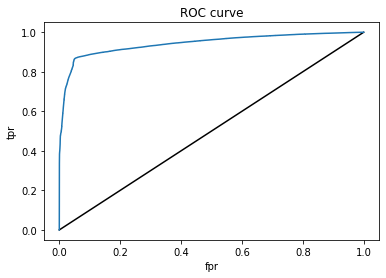

In [ ]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

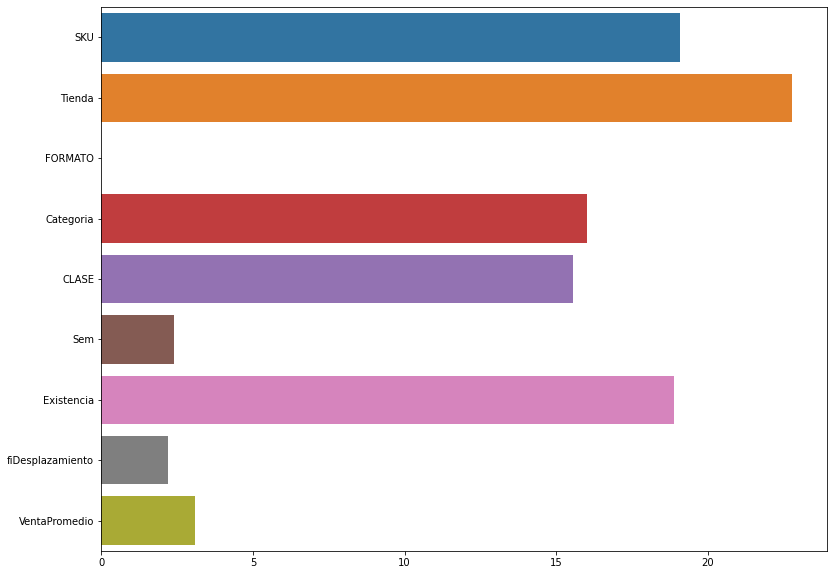

In [ ]:
# Graficar la importancia de las variables
fi2 = pd.Series(model.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots(figsize = (13,10))
sns.barplot(x=fi2.values, y=fi2.index, ax=ax)
plt.show()

In [ ]:
copia_general = X_val.copy()
copia_general['Y_Faltante'] = y_val
copia_general['Predicción_Ago'] = model.predict(X_val)
copia_general.to_csv('General.csv',index=True)

# Vamos a incorporar un corrector

In [ ]:
# Se obtienen muy poquitos ejemplos erroneos del conjunto de entrenamiento
#copia = pd.concat([data,data_val],join='inner')
#target = copia.drop('Y_Faltante',axis=1)
#y_pred_train = model.predict(copia)
#pred_cb_train = model.predict_proba(copia)
#pred_cb = pd.DataFrame(y_prob_train).assign(CBPred=pd.Series(y_pred_train))

In [ ]:
# Predicciones del conjunto de entrenamiento
#y_pred_train = model.predict(X_train)
#y_prob_train = model.predict_proba(X_train)
#pred_cb_train = pd.DataFrame(y_prob_train).assign(CBPred=pd.Series(y_pred_train))
#train_target = pd.Series(y_train)

In [ ]:
nuevos_datos = data_val.copy()
nuevos_datos['Predicción_Ago'] = model.predict(nuevos_datos.drop('Y_Faltante',axis=1))

In [ ]:
# 0 va a indicar acuerdo y 1 indica desacuerdo
faltante_real = nuevos_datos['Y_Faltante']
faltante_predicho = nuevos_datos['Predicción_Ago']
verdaderos_positivos = (faltante_real + faltante_predicho) % 2
nuevos_datos['Acuerdo'] = verdaderos_positivos 

In [ ]:
# Aquí reportamos el numero de acuerdos y desacuerdos
verdaderos_positivos.value_counts()

0    2388708
1     136263
dtype: int64

yes %: 5.396616436386794- no %: 94.6033835636132


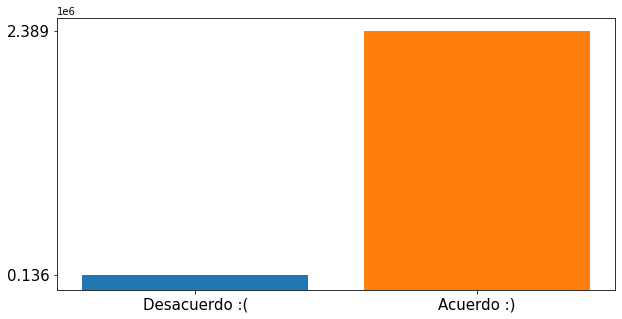

In [ ]:
# Revisamos (de nuevo) la proporción de datos
target = verdaderos_positivos
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Desacuerdo :(", yes)
plt.bar("Acuerdo :)", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
buenas = nuevos_datos[nuevos_datos['Acuerdo']==0]
malas = nuevos_datos[nuevos_datos['Acuerdo']==1]

In [ ]:
len(buenas)

2388708

In [ ]:
len(malas)

136263

In [ ]:
pieza = buenas[0:len(malas)]

In [ ]:
len(pieza)

136263

In [ ]:
import math
import random 
# El imput 'frame' se refiere al dataframe al cual se le extraerá un subconjunto de elementos faltantes de anaquel en una proporción dada.
# Porcentaje_faltante es el porcentaje deseado de elementos que son NO faltante (es decir, el procentaje mayor). 

# Guardamos el número de elementos no faltantes en una variable
num_buenas = buenas.shape[0]

def extrae(frame,procentaje_no_faltante):
  faltantes = frame[frame['Y_Faltante']==1] # Extraemos los elementos que son faltante de anaquel
  a = (num_buenas*100)/procentaje_no_faltante - num_buenas 
  num_deseado_faltantes = int(math.floor(a))
  b = random.randint(0,faltantes.shape[0]-2)
  df = faltantes[b:b+1] # Tomamos un elemento faltante al azar
  while df['Y_Faltante'].shape[0] < num_deseado_faltantes:
    c = random.randint(0,faltantes.shape[0]-3)
    df2 = faltantes.iloc[c:c+1]
    df3 = pd.concat([df,df2],ignore_index=True)
    df = df3
  return df

In [ ]:
# Algunas funciones auxiliares 
import random 
import math

# Esta función va a crear un dataframe con porcentaje dado de faltante original
def crea_faltante(frame,porcentaje):
  
  num_deseado_faltantes = int(math.floor((frame.shape[0]*porcentaje)/100))
  a = random.randint(0,frame.shape[0]-2) # Tomamos el índice de una fila al azar
  df = frame[a:a+1] # Elegimos un renglón del dataset al azar para comenzar a construir un nuevo dataframe
  while df['Y_Faltante'].value_counts()[1] < num_deseado_faltantes:
    r = random.randint(0,frame.shape[0]-3)
    if frame['Y_Faltante'].iloc[r] == 1:
      df2 = frame.iloc[a:a+1]
      df3 = pd.concat([df,df2],ignore_index=True)
      df = df3
  return df


# Esta función va a crear un dataframe con porcentaje dado de faltante original
def crea_no_faltante(frame,porcentaje):
  num_deseado_faltantes = int(math.floor((frame.shape[0]*porcentaje)/100))
  a = random.randint(0,frame.shape[0]-2) # Tomamos el índice de una fila al azar
  df = frame[a:a+1] # Elegimos un renglón del dataset al azar para comenzar a construir un nuevo dataframe
  while df['Y_Faltante'].value_counts()[1] < num_deseado_faltantes:
    r = random.randint(0,frame.shape[0]-3)
    if frame['Y_Faltante'].iloc[r] == 0:
      df2 = frame.iloc[a:a+1]
      df3 = pd.concat([df,df2],ignore_index=True)
      df = df3

In [ ]:
# El argumento de extrae vá a ser "y" donde  x = 100% - y & "y" es el porcentaje (del total) que quieres extraer
frame_final = pd.concat([malas,pieza],axis=0)

In [ ]:
frame_final

,SKU,Tienda,FORMATO,Categoria,CLASE,Sem,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante,Predicción_Ago,Acuerdo
10,3360908,CHEDRAUI VILLA CARRIZAL,CHEDRAUI AB,SHAMPOOS Y ACONDICIONADOR,SHAMPOOS Y ACONDICIONADOR,23,0.0,5.0,680.00,1,0,1
17,3694585,CHEDRAUI VILLA CARRIZAL,CHEDRAUI AB,AROMATIZANTES,AROMATIZANTES,23,0.0,15.0,1098.75,1,0,1
139,3236368,CHEDRAUI VILLA CARRIZAL,CHEDRAUI AB,JUGOS Y NÃCTARES,JUGOS Y NÃCTARES,22,9.0,28.0,753.20,1,0,1
192,3735514,CHEDRAUI VILLA CARRIZAL,CHEDRAUI AB,PAÃALES,PAÃALES,22,0.0,6.0,1525.50,1,0,1
197,3401285,CHEDRAUI VILLA CARRIZAL,CHEDRAUI AB,FRAGANCIAS,FRAGANCIAS,23,4.0,21.0,1610.07,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
147257,3447962,SUPERCITO MAGDALENA CONTRERAS,SUPERCITO CD,LIMPIEZA CALZADO,LIMPIEZA CALZADO,22,0.0,0.0,0.00,1,1,0
147258,3010221,SUPERCITO MAGDALENA CONTRERAS,SUPERCITO CD,PESCADOS Y MARISCOS ENLATADOS,PESCADOS Y MARISCOS ENLATADOS,22,38.0,28.0,802.48,0,0,0
147259,3001968,SUPERCITO MAGDALENA CONTRERAS,SUPERCITO CD,REFRESCOS Y SODAS,REFRESCOS Y SODAS,23,139.0,1588.0,17801.48,0,0,0
147260,3691253,SUPERCITO MAGDALENA CONTRERAS,SUPERCITO CD,HARINAS,HARINAS,22,68.0,9.0,121.50,0,0,0


### Aquí la idea es construir una muestra que sea 50 vs 50 tanto en acuerdo
### Posiblemente sea interesante también hacer una prueba con un modelo que tenga 50/50 tanto en acuerdo como en faltante contra no faltante 

yes %: 50.0- no %: 50.0


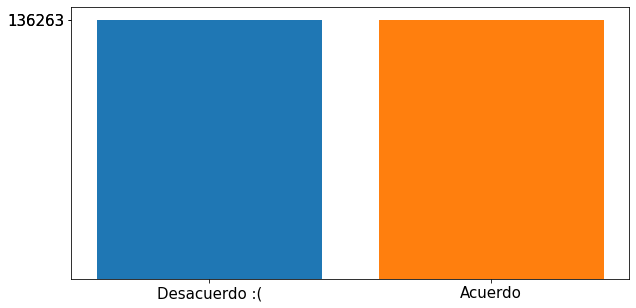

: 

In [ ]:
# Revisamos la proporción de datos
target = frame_final['Acuerdo']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Desacuerdo :(", yes)
plt.bar("Acuerdo", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# CHEDRAUI CD

In [ ]:
def segmentador_formato(frame,cadena):
    arreglo = frame[frame['FORMATO']==cadena]
    return arreglo 

In [ ]:
chedraui_cd = segmentador_formato(data,'CHEDRAUI CD')
chedraui_cd_val = segmentador_formato(data_val,'CHEDRAUI CD')

yes %: 50.33705612681122- no %: 49.66294387318877


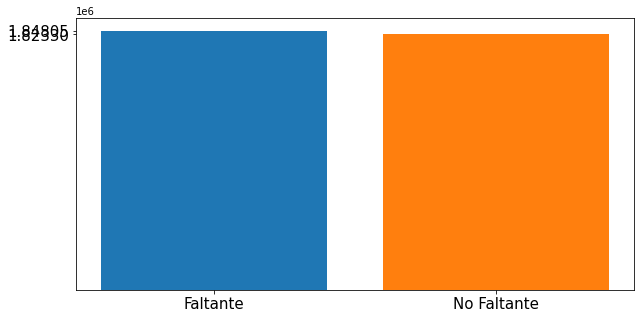

In [ ]:
# Revisamos la proporción de datos
target = chedraui_cd['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = chedraui_cd[chedraui_cd["Y_Faltante"] == 1]
data_no = chedraui_cd[chedraui_cd["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
chedraui_cd = balanced_data.reset_index(drop=True)

yes %: 50.0- no %: 50.0


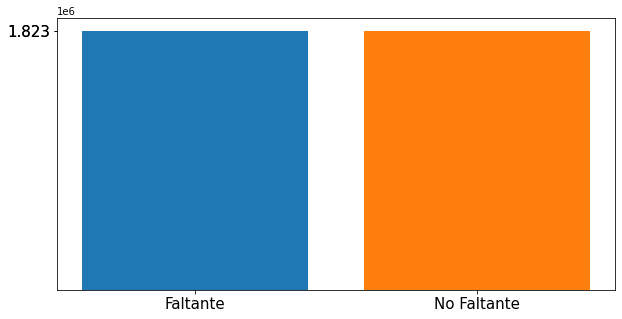

In [ ]:
# Verificamos que el conjunto de datos está perfectamente balanceado
# Revisamos la proporción de datos
target = chedraui_cd['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
chedraui_cd = chedraui_cd.drop('FORMATO',axis=1)
chedraui_cd_val = chedraui_cd_val.drop('FORMATO',axis=1)

In [ ]:
X_train = chedraui_cd.drop('Y_Faltante',axis=1)
y_train = chedraui_cd.Y_Faltante
X_val = chedraui_cd_val.drop('Y_Faltante',axis=1)
y_val = chedraui_cd_val.Y_Faltante

In [ ]:
indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos

array([0, 1, 2, 3, 4])

In [ ]:
num_ind = np.where(X_train.dtypes != object)[0]
num_ind

array([5, 6, 7])

In [ ]:
model = CatBoostClassifier(
    l2_leaf_reg=int(1.0),
    custom_loss=[metrics.Accuracy()],
    random_seed=0,
    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
    task_type='GPU',
    #iterations=190
)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=indices_categoricos,
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6465015	test: 0.6628442	best: 0.6628442 (0)	total: 293ms	remaining: 4m 52s
1:	learn: 0.6021024	test: 0.6301307	best: 0.6301307 (1)	total: 611ms	remaining: 5m 5s
2:	learn: 0.5642724	test: 0.6020191	best: 0.6020191 (2)	total: 984ms	remaining: 5m 27s
3:	learn: 0.5312606	test: 0.5784021	best: 0.5784021 (3)	total: 1.28s	remaining: 5m 18s
4:	learn: 0.5001281	test: 0.5540763	best: 0.5540763 (4)	total: 1.7s	remaining: 5m 37s
5:	learn: 0.4727581	test: 0.5316480	best: 0.5316480 (5)	total: 2.07s	remaining: 5m 43s
6:	learn: 0.4484094	test: 0.5093973	best: 0.5093973 (6)	total: 2.35s	remaining: 5m 32s
7:	learn: 0.4265439	test: 0.4906285	best: 0.4906285 (7)	total: 2.79s	remaining: 5m 45s
8:	learn: 0.4069055	test: 0.4715589	best: 0.4715589 (8)	total: 3.13s	remaining: 5m 44s
9:	learn: 0.3900856	test: 0.4542807	best: 0.4542807 (9)	total: 3.5s	remaining: 5m 46s
10:	learn: 0.3748958	test: 0.4394310	best: 0.4394310 (10)	total: 3.92s	remaining: 5m 52s
11:	learn: 0.3611204	test: 0.4248702	best: 0

In [ ]:
print('Ago Model')
print('Tree count: {}'.format(model.tree_count_))
print('Accuracy: {:.5}'.format(accuracy_score(y_val, model.predict(X_val))))
print('True Positive Rate: {:.5}'.format(recall_score(y_val, model.predict(X_val))))
print('Precision: {:.5}'.format(precision_score(y_val, model.predict(X_val))))
print('Balanced Accuracy: {:.5}'.format(balanced_accuracy_score(y_val, model.predict(X_val))))
print('F1 Score: {:.5}'.format(f1_score(y_val, model.predict(X_val))))

Ago Model
Tree count: 404
Accuracy: 0.97683
True Positive Rate: 0.8855
Precision: 0.92559
Balanced Accuracy: 0.93767
F1 Score: 0.9051


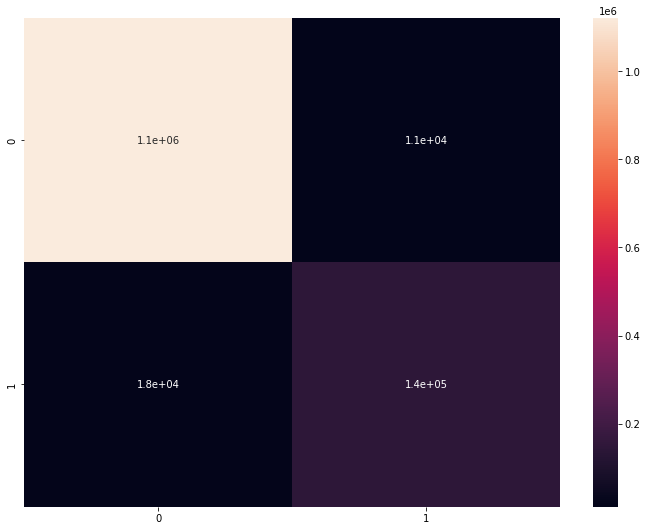

In [ ]:
y_pred = model.predict(X_val)
# Dibujamos también la matriz de confusión para nuestro modelo
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
y_pred = model.predict(X_val)
prediction_probs = model.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9768257488245589
True Positive Rate 0.8854981209408298
Precision 0.9837725525018558
Balanced accuracy 0.9376734785309758
f1 score 0.9051000196178941


In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(1121180, 11498, 18494, 143023)

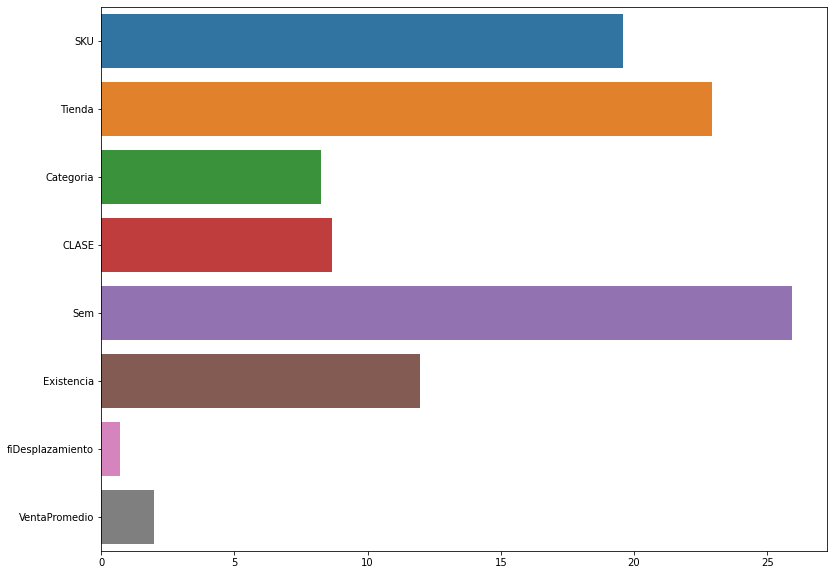

In [ ]:
# Graficar la importancia de las variables
fi2 = pd.Series(model.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots(figsize = (13,10))
sns.barplot(x=fi2.values, y=fi2.index, ax=ax)
plt.show()

In [ ]:
copia_general = X_val.copy()
copia_general['Y_Faltante'] = y_val
copia_general['Predicción_Ago'] = model.predict(X_val)
copia_general.to_csv('chedrauicd.csv',index=True)